# Régression logistique et courbe ROC

Prédire la couleur d'un vin à partir de ses composants et visualiser la performance avec une courbe ROC.

In [22]:
%matplotlib inline

In [23]:
from teachpyx.datasets import load_wines_dataset

data = load_wines_dataset()
X = data.drop(["quality", "color"], axis=1)
y = data["color"]

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
from sklearn.linear_model import LogisticRegression

clr = LogisticRegression(max_iter=10000)
clr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

La première façon de vérifier que le modèle a marché consiste à regarder la matrice de confusion.

In [26]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, clr.predict(X_test))
conf

array([[ 381,   21],
       [   9, 1214]])

Les coefficients sur la diagonale indique les éléments bien classés, les coefficients en dehors de ceux que le classifieur a mis dans la mauvaise classe.

In [27]:
import pandas

cf = pandas.DataFrame(conf, columns=["prédit " + _ for _ in clr.classes_])
cf.index = ["vrai " + _ for _ in clr.classes_]
cf

,prédit red,prédit white
vrai red,381,21
vrai white,9,1214


Un classifieur construit une frontière entre deux classes, la distance d'un point à la frontière constitue une information importante. Plus elle est grande, plus le modèle est confiant. Cette distance est souvent appelée *score*.

In [28]:
clr.decision_function(X_test)

array([ 6.81334302, -2.96101497,  7.56100306, ..., -9.00136661,
        1.082343  ,  4.15449278], shape=(1625,))

Mais on préfère les probabilités quand elles sont disponibles :

In [29]:
clr.predict_proba(X_test)

array([[1.09780622e-03, 9.98902194e-01],
       [9.50781512e-01, 4.92184876e-02],
       [5.20082410e-04, 9.99479918e-01],
       ...,
       [9.99876774e-01, 1.23226080e-04],
       [2.53062882e-01, 7.46937118e-01],
       [1.54512611e-02, 9.84548739e-01]], shape=(1625, 2))

Voyons comment le score est distribué :

In [30]:
score = clr.decision_function(X_test)
dfsc = pandas.DataFrame(score, columns=["score"])
dfsc["color"] = y_test
dfsc.head()

,score,color
0,6.813343,NaN
1,-2.961015,NaN
2,7.561003,NaN
3,9.006834,NaN
4,-7.184946,red


Visiblement, pandas n'a pas compris ce que je voulais qu'il fasse. Il a utilisé les indices de la série *y_test* et a utilisé *y_test.index* comme indice de tableau. Changeons cela.

In [31]:
dfsc = pandas.DataFrame(score, columns=["score"])
dfsc["color"] = y_test.values
dfsc.head()

,score,color
0,6.813343,white
1,-2.961015,red
2,7.561003,white
3,9.006834,white
4,-7.184946,red


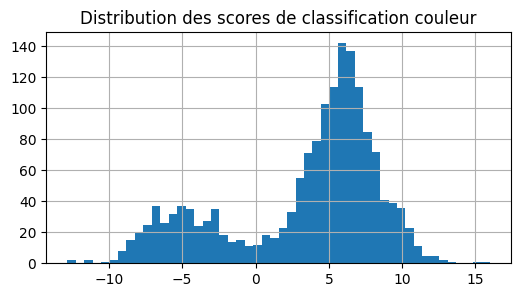

In [32]:
ax = dfsc["score"].hist(bins=50, figsize=(6, 3))
ax.set_title("Distribution des scores de classification couleur");

Deux modes, probablement les deux classes. Pour en être sûr :

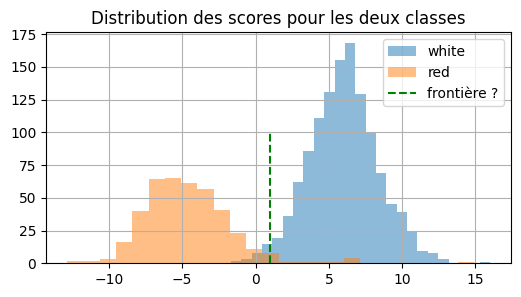

In [33]:
ax = dfsc[dfsc["color"] == "white"]["score"].hist(
    bins=25, figsize=(6, 3), label="white", alpha=0.5
)
dfsc[dfsc["color"] == "red"]["score"].hist(bins=25, ax=ax, label="red", alpha=0.5)
ax.set_title("Distribution des scores pour les deux classes")
ax.plot([1, 1], [0, 100], "g--", label="frontière ?")
ax.legend();

Il y a quelques confusions autour de 0 mais le modèle est pertinent au sens où la frontière entre les deux classes est assez nette : les deux cloches ne se superposent pas. Voyons avec les probabilités :

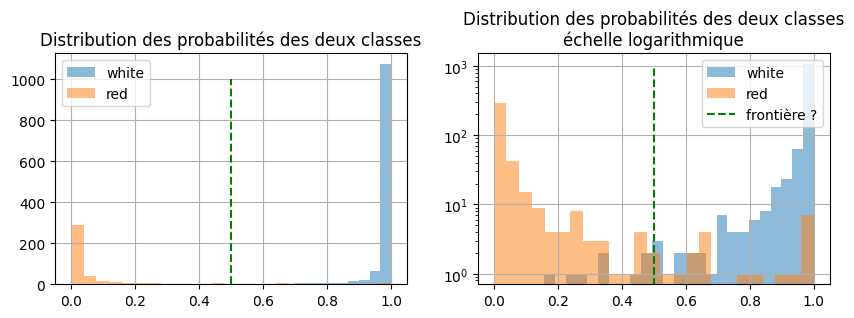

In [34]:
proba = clr.predict_proba(X_test)[:, 1]
dfpr = pandas.DataFrame(proba, columns=["proba"])
dfpr["color"] = y_test.values

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
dfpr[dfpr["color"] == "white"]["proba"].hist(
    bins=25, label="white", alpha=0.5, ax=ax[0]
)
dfpr[dfpr["color"] == "red"]["proba"].hist(bins=25, label="red", alpha=0.5, ax=ax[0])
ax[0].set_title("Distribution des probabilités des deux classes")
ax[0].legend()
dfpr[dfpr["color"] == "white"]["proba"].hist(
    bins=25, label="white", alpha=0.5, ax=ax[1]
)
dfpr[dfpr["color"] == "red"]["proba"].hist(bins=25, label="red", alpha=0.5, ax=ax[1])
ax[0].plot([0.5, 0.5], [0, 1000], "g--", label="frontière ?")
ax[1].plot([0.5, 0.5], [0, 1000], "g--", label="frontière ?")
ax[1].set_yscale("log")
ax[1].set_title("Distribution des probabilités des deux classes\néchelle logarithmique")
ax[1].legend();

Plus l'aire commune aux deux distributions est petite, plus le modèle est confiant. Cette aire commune est reliée à la courbe [ROC](https://fr.wikipedia.org/wiki/Courbe_ROC).

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

probas = clr.predict_proba(X_test)
fpr0, tpr0, thresholds0 = roc_curve(
    y_test, probas[:, 0], pos_label=clr.classes_[0], drop_intermediate=False
)
fpr0.shape

(1544,)

*fpr* désigne le [False Positive Rate](https://en.wikipedia.org/wiki/Precision_and_recall) autrement dit le taux de faux positive, si la tâche est déterminer si un vin est blanc, le taux désigne la proportion de vins rouges classés par le classifieur parmi les vins blancs. C'est l'erreur de classification. *tpr* désigne le nombre de [True Positive Rate](https://en.wikipedia.org/wiki/Precision_and_recall). C'est... A vrai dire, cette dénomination est toujours aussi absconce pour moi. Je leur préfère les formules mathématiques. On souhaite toujours classer les vins blancs. *True* et *False* ne sont pas vrai ou faux mais le nom de deux classes.

$$
\begin{array}{rcl}FPR(s) &=& \sum_{i=1}^n \mathbb{1}_{score(X_i) \geqslant s}\mathbb{1}_{y_i == red}\\ TPR(s) &=& \sum_{i=1}^n \mathbb{1}_{score(X_i) \geqslant s}\mathbb{1}_{y_i == blanc}\end{array}
$$

In [36]:
dftp = pandas.DataFrame(dict(fpr=fpr0, tpr=tpr0, threshold=thresholds0)).copy()
dftp.head(n=2)

,fpr,tpr,threshold
0,0.0,0.000000,inf
1,0.0,0.002488,0.999997


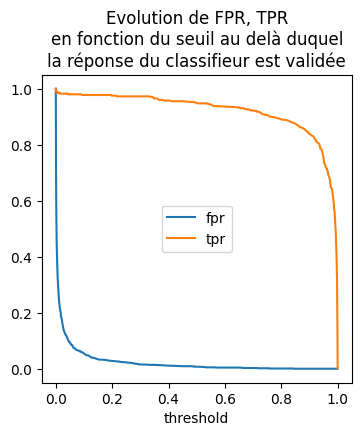

In [37]:
ax = dftp.plot(x="threshold", y=["fpr", "tpr"], figsize=(4, 4))
ax.set_title(
    "Evolution de FPR, TPR\nen fonction du seuil au delà duquel\n"
    + "la réponse du classifieur est validée"
);

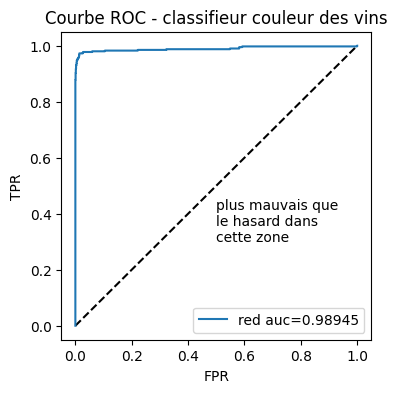

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], "k--")
# aucf = roc_auc_score(y_test == clr.classes_[0], probas[:, 0]) # première façon
aucf = auc(fpr0, tpr0)  # seconde façon
ax.plot(fpr0, tpr0, label=clr.classes_[0] + " auc=%1.5f" % aucf)
ax.set_title("Courbe ROC - classifieur couleur des vins")
ax.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.legend();

La mesure [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) ou Area Under the Curve est l'aire sous la courbe. Elle est égale à la probabilité que le score d'un exemple classé rouge à raison soit inférieur à un exemple classé rouge à tort. On vérifie.

In [39]:
from random import randint

n1, n2 = 0, 0
yt = y_test.values

for n in range(0, 100000):
    i = randint(0, len(yt) - 1)
    j = randint(0, len(yt) - 1)
    s1, p1 = probas[i, 0], yt[i] == clr.classes_[0]
    s2, p2 = probas[j, 0], yt[j] == clr.classes_[0]
    if p1 != p2:
        if p1:
            if s1 < s2:
                n1 += 1
            else:
                n2 += 1
        else:
            if s1 > s2:
                n1 += 1
            else:
                n2 += 1
print(n2 * 1.0 / (n1 + n2))

0.9899276721135816


Presque cela, la fonction [auc](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) utilise la fontion [trapz](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.trapz.html) et qui calcule une aire et non pas une probabilité comme-ci dessus. Ce [théorème](https://sdpython.github.io/doc/mlstatpy/dev/c_metric/roc.html) qui démontre que cette aire a un lien direct avec les scores de classification. Deux autres métriques sont très utilisées, la [précision](https://en.wikipedia.org/wiki/Precision_and_recall) et le [rappel](https://en.wikipedia.org/wiki/Precision_and_recall). Pour chaque classifieur, on peut déterminer un seuil *s* au delà duquel la réponse est validée avec une bonne confiance. Parmi toutes les réponses validées, la précision est le nombre de réponses correctes rapporté au nombre de réponses validées, le rappel est le nombre de réponses correctes rapportées à toutes qui aurait dû être validées. On calcule aussi la métrique *F1* qui est une sorte de moyenne entre les deux.

In [40]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test, probas[:, 0], pos_label=clr.classes_[0]
)

In [41]:
dfpr = pandas.DataFrame(
    dict(precision=precision, recall=recall, threshold=[0] + list(thresholds))
)
dfpr["F1"] = 2 * (dfpr.precision * dfpr.recall) / (dfpr.precision + dfpr.recall)
dfpr.head(n=2)

,precision,recall,threshold,F1
0,0.247385,1.0,0.000000e+00,0.396645
1,0.247537,1.0,1.140734e-07,0.396841


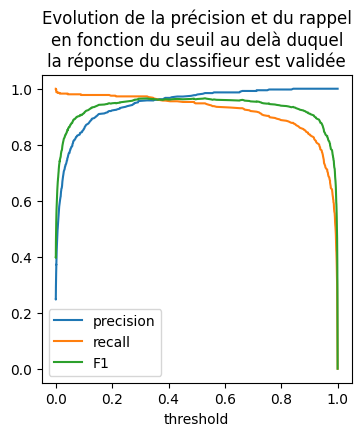

In [42]:
ax = dfpr.plot(x="threshold", y=["precision", "recall", "F1"], figsize=(4, 4))
ax.set_title(
    "Evolution de la précision et du rappel\nen fonction du seuil au delà duquel\n"
    + "la réponse du classifieur est validée"
);